# Anomaly Detection Using Autoencoders

## Introduction
Deep learning has revolutionized many fields by enabling models to learn intricate patterns from data. This project focuses on anomaly detection using autoencoders, a type of unsupervised deep learning model. Autoencoders are designed to reconstruct input data, making them effective for identifying anomalies like fraudulent transactions, where reconstruction errors are significantly higher.  
Kaggle.com serves as the source for the dataset used in this project, demonstrating its value as a resource for data science challenges. The purpose of this project is to develop, train, and evaluate a deep learning-based anomaly detection system using data from Kaggle.

## Project Goals and Objectives
The primary goals of this project include:
- Selecting and preparing the "Credit Card Fraud Detection" dataset from Kaggle.
- Developing a deep learning autoencoder model to detect anomalies in transactional data.
- Optimizing the model to achieve high accuracy, precision, recall, and F1-score metrics for fraud detection.
- Evaluating the model's performance and identifying potential improvements.

## Tools and Libraries
The project utilizes the following libraries:
- **`numpy`, `pandas`**: Data manipulation and processing.  
- **`matplotlib`, `seaborn`**: Visualization and exploratory data analysis.  
- **`scikit-learn`**: Data preprocessing, evaluation metrics, and resampling techniques.  
- **`tensorflow`**: Building and training deep learning autoencoders.  
- **`xgboost`, `optuna`**: Advanced modeling and hyperparameter optimization.  
- **`imbalanced-learn`**: Addressing class imbalance in the dataset.  
- **`kagglehub`**: Automating dataset download from Kaggle.

In [1]:
# Install required libraries directly from the notebook (optional)
import sys
import subprocess


def install_requirements():
    try:
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", "-r", "requirements.txt"])
        print("All required libraries installed successfully.")
    except Exception as e:
        print("Error installing libraries:", e)

# comment the following line to disable automatic installation
install_requirements()

All required libraries installed successfully.


In [ ]:
# Importing libraries
import os
import random as rd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers, models

# Advanced libraries
import xgboost as xgb
import optuna
from imblearn.over_sampling import SMOTE

# Dataset libraries
import kagglehub

In [3]:
SEED = 42
# SEED = rd.randint(1, 1000) #! untag this line if u want a random seed each run

rd.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


## Data Acquisition and Preprocessing
- **Dataset**: The "Credit Card Fraud Detection" dataset contains anonymized transactional data. It includes both fraudulent and non-fraudulent transactions.  
- **Preprocessing**:
  - Scaling numerical features for consistency.
  - Addressing class imbalance using SMOTE (Synthetic Minority Oversampling Technique).
  - Splitting data into training and testing sets for model development and evaluation.
  
### Dataset Handling
The dataset is dynamically downloaded using `kagglehub`, ensuring reproducibility and a lightweight repository.

### Steps:
1. Check if the dataset exists locally.
2. If not, use `kagglehub` to download and extract it.
3. Load the dataset for further processing.


In [4]:
try:
    # Download the dataset using kagglehub
    path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
    
    # Load the CSV file
    csv_file = os.path.join(path, "creditcard.csv")
    data = pd.read_csv(csv_file)
    print("Dataset loaded successfully!")
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

Dataset loaded successfully!


In [5]:
# Check the shape of the dataset
print("Dataset Shape:", data.shape)

# Display column information
print("\nColumn Information:")
print(data.info())

# Summary statistics
print("\nDataset Summary Statistics:")
print(data.describe())

Dataset Shape: (284807, 31)

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20 


Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64


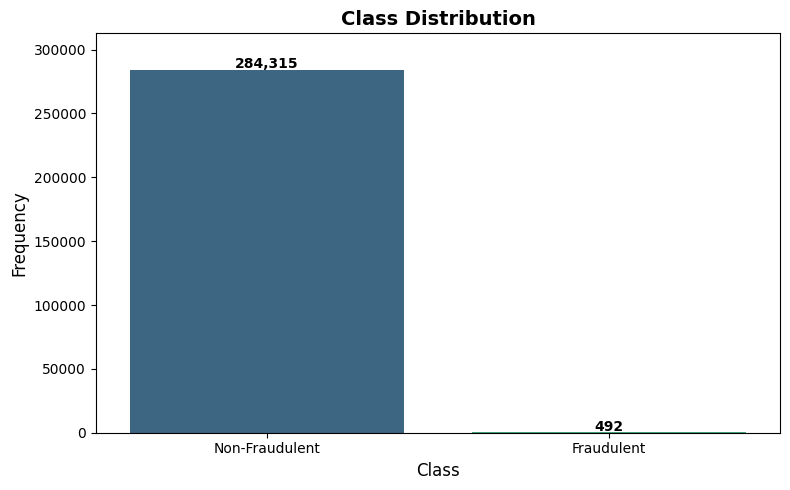

In [6]:
# Analyze the class distribution
class_counts = data['Class'].value_counts()
print("\nClass Distribution:")
print(class_counts)

# Visualize the class distribution with counts
plt.figure(figsize=(8, 5))
sns.barplot(
    x=class_counts.index,
    y=class_counts.values,
    hue=class_counts.index,
    dodge=False,
    palette="viridis",
    legend=False  # Suppress legend since it's unnecessary for this chart
)
plt.title("Class Distribution", fontsize=14, fontweight="bold")
plt.xlabel("Class", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks([0, 1], ["Non-Fraudulent", "Fraudulent"], fontsize=10)

# Annotate exact values on the bars
for i, value in enumerate(class_counts.values):
    plt.text(i, value + 1000, f"{value:,}", ha="center",
             fontsize=10, color="black", fontweight="bold")

plt.ylim(0, class_counts.max() * 1.1)  # Adjust y-axis for better visualization
plt.tight_layout()
plt.show()

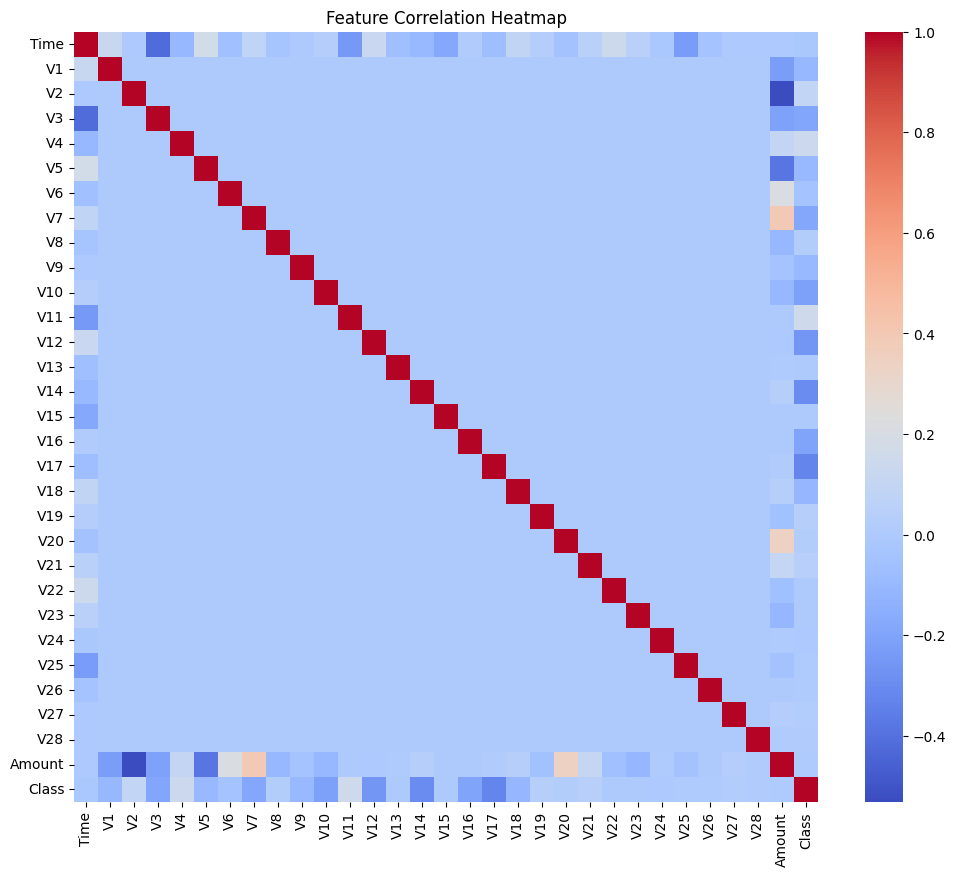

In [7]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

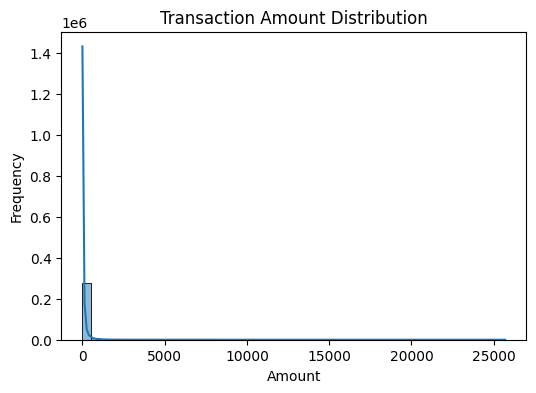

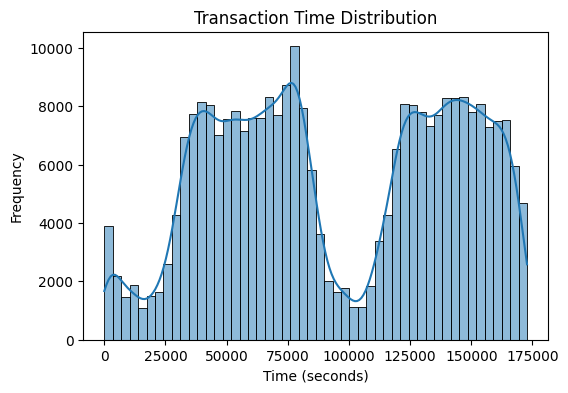

In [8]:
# Distribution of the 'Amount' feature
plt.figure(figsize=(6, 4))
sns.histplot(data['Amount'], bins=50, kde=True)
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

# Distribution of the 'Time' feature
plt.figure(figsize=(6, 4))
sns.histplot(data['Time'], bins=50, kde=True)
plt.title("Transaction Time Distribution")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency")
plt.show()

In [9]:
# Check for missing values
print("\nMissing Values in the Dataset:")
print(data.isnull().sum())


Missing Values in the Dataset:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [10]:
# Features to scale
scaler = StandardScaler()
data[['Scaled_Amount', 'Scaled_Time']] = scaler.fit_transform(
    data[['Amount', 'Time']])

# Drop original 'Amount' and 'Time' columns 
data = data.drop(columns=['Amount', 'Time'])
print("\nFirst 5 rows after scaling:")
print(data.head())


First 5 rows after scaling:
         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V22       V23       V24       V25  \
0  0.098698  0.363787  0.090794  ...  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425 -0.166974  ... -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  0.207643  ...  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024 -0.054952  ...  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  0.753074  ...  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Class 

In [ ]:
# Separate features and target variable
X = data.drop(columns=['Class'])
y = data['Class']

# Apply SMOTE for class balancing
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("\nClass distribution after applying SMOTE:")
print(pd.Series(y_resampled).value_counts())

In [12]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42)

print("\nTraining and Testing Data Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


Training and Testing Data Shapes:
X_train: (454904, 30) y_train: (454904,)
X_test: (113726, 30) y_test: (113726,)


## Building and Training the Autoencoder



- **Model Architecture**:
  - The project uses autoencoders with fully connected layers and ReLU activations for encoding and decoding.
  - Dropout layers are incorporated to prevent overfitting.
- **Training**:
  - Pre-tuned autoencoder for baseline evaluation.
  - Hyperparameter optimization using `Optuna` to enhance model performance.
  - Evaluation based on reconstruction errors to identify anomalies.

### Definition
An autoencoder is a type of neural network designed to learn efficient representations of input data. It consists of two main components:
1. **Encoder**: Compresses the input data into a smaller representation.
2. **Decoder**: Reconstructs the data from the compressed representation.



### Purpose
In this project, the autoencoder is trained exclusively on non-fraudulent transactions (`Class = 0`). It learns to reconstruct normal transaction patterns. Fraudulent transactions (`Class = 1`) are expected to result in higher reconstruction errors, which will be used to identify anomalies.

### Steps
1. **Prepare Training Data**: Use only non-fraudulent transactions to train the autoencoder.
2. **Define the Model**: Build an encoder-decoder structure with a bottleneck layer for dimensionality reduction.
3. **Train the Model**: Optimize the autoencoder to minimize reconstruction error.
4. **Evaluate Reconstruction Errors**: Compute reconstruction errors on the test data.
5. **Set Threshold**: Determine an anomaly threshold based on the reconstruction error distribution.
6. **Classify Transactions**: Identify transactions as fraudulent or non-fraudulent based on the threshold.


In [13]:
# Filter non-fraudulent transactions
X_train_autoencoder = X_train[y_train == 0]

print("Training data shape for autoencoder:", X_train_autoencoder.shape)

Training data shape for autoencoder: (227565, 30)


In [14]:
# Define the autoencoder model
input_dim = X_train_autoencoder.shape[1]

autoencoder = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),  # Dropout to prevent overfitting
    layers.Dense(8, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(input_dim, activation='sigmoid')
])

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,286 (5.02 KB)

 Trainable params: 1,286 (5.02 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train the autoencoder on non-fraudulent data
history = autoencoder.fit(
    X_train_autoencoder,
    X_train_autoencoder,
    epochs=50,  #? Reduced for faster testing
    batch_size=256,
    validation_split=0.2,
    verbose=1
)

# Save the pre-tuned model for later reference
pre_tuned_model = autoencoder

autoencoder.save('models\\pre_optimized_model.h5')
print("Pre_Optimized model saved.")

# Evaluate the pre-tuned model
pre_tuned_reconstructed = pre_tuned_model.predict(X_test)
pre_tuned_reconstruction_errors = np.mean(
    np.square(X_test - pre_tuned_reconstructed), axis=1
)
pre_tuned_threshold = np.percentile(
    pre_tuned_reconstruction_errors[y_test == 0], 95
)
pre_tuned_predicted_class = (
    pre_tuned_reconstruction_errors > pre_tuned_threshold
).astype(int)

# Save Pre-Tuned Metrics
pre_tuned_metrics = {
    'precision': classification_report(y_test, pre_tuned_predicted_class, output_dict=True)['1']['precision'],
    'recall': classification_report(y_test, pre_tuned_predicted_class, output_dict=True)['1']['recall'],
    'f1-score': classification_report(y_test, pre_tuned_predicted_class, output_dict=True)['1']['f1-score'],
    'roc_auc': roc_auc_score(y_test, pre_tuned_reconstruction_errors)
}

# Print Pre-Tuned Model Metrics
print("Pre-Tuned Model Metrics:")
print(pre_tuned_metrics)

Epoch 1/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1291 - val_loss: 0.9345
Epoch 2/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9719 - val_loss: 0.9165
Epoch 3/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9568 - val_loss: 0.9004
Epoch 4/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9485 - val_loss: 0.8925
Epoch 5/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9430 - val_loss: 0.8882
Epoch 6/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9395 - val_loss: 0.8850
Epoch 7/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9366 - val_loss: 0.8830
Epoch 8/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9346 - val_loss: 0.8806
Epoch 9/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9325 - val_loss: 0.8783
Epoch 10/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9308 - val_loss: 0.8769
Epoch 11/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9295 - val_loss: 0.8757
Epoch 12/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Pre_Optimized model saved.
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 2s 677us/step
Pre-Tuned Model Metrics:
{'precision': 0.9453526659349547, 'recall': 0.8616786015164279, 'f1-score': 0.9015783819519048, 'roc_auc': np.float64(0.9324806772339107)}


3554/3554 ━━━━━━━━━━━━━━━━━━━━ 2s 614us/step
              V1        V2        V3        V4        V5        V6        V7  \
437378  0.608592  1.172338 -5.139426  2.183258 -0.686494 -0.113160 -3.485461   
504222 -1.558593  2.423089 -3.040602  2.092190 -1.321602 -1.013416 -2.787381   
4794   -0.851994  0.935553  2.188136  0.709286  0.178930 -0.349335  0.857609   
388411 -4.536215  5.298679 -6.009102  5.311628 -4.327698 -1.546662 -6.390830   
424512  0.357583  1.249764 -1.978700  2.241978 -1.325245 -0.975516 -2.525424   

              V8        V9       V10  ...       V23       V24       V25  \
437378  1.095828 -0.764425 -5.211864  ...  0.050265 -0.781124  0.153403   
504222  0.979579 -2.167936 -4.868367  ... -0.230691 -0.514474  0.212680   
4794   -0.416252  1.066375 -0.474828  ... -0.096893  0.404476  0.377388   
388411  3.259754 -5.244951 -7.534241  ...  0.114787 -0.167112 -0.241855   
424512  0.631357 -1.160787 -3.161084  ... -0.247070 -0.189943  0.780034   

             V26       

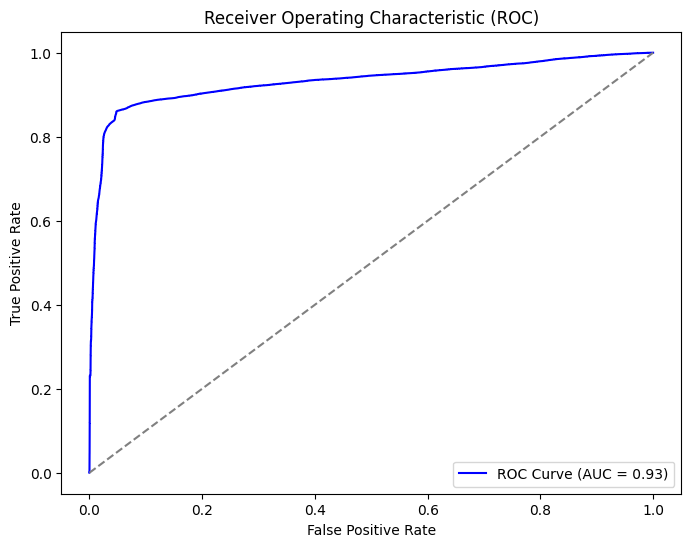

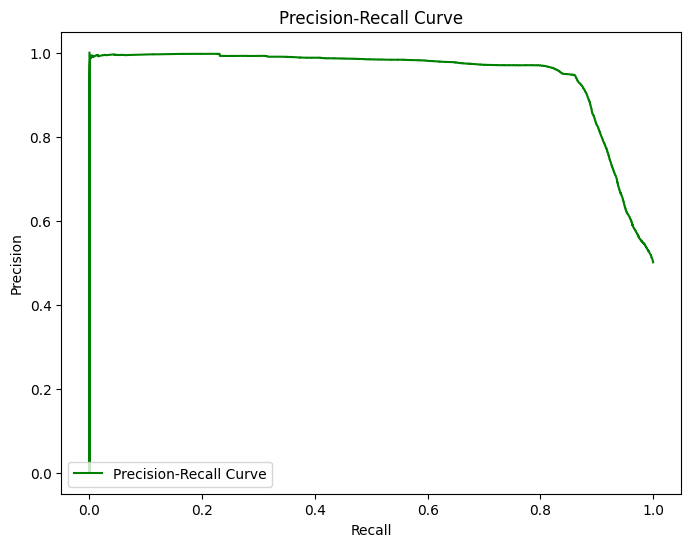

Optimal Threshold for Reconstruction Error: 1.9063847405861687


In [16]:
# Reconstruct the test set
reconstructed = autoencoder.predict(X_test)

# Compute reconstruction error
reconstruction_errors = np.mean(np.square(X_test - reconstructed), axis=1)

# Add reconstruction errors to the test set for analysis
X_test_with_errors = pd.DataFrame(
    X_test, columns=[f"V{i}" for i in range(1, X_test.shape[1] + 1)])
X_test_with_errors['Reconstruction_Error'] = reconstruction_errors
X_test_with_errors['Class'] = y_test.values

print(X_test_with_errors.head())


# ROC curve
fpr, tpr, thresholds = roc_curve(
    X_test_with_errors['Class'], reconstruction_errors)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(
    X_test_with_errors['Class'], reconstruction_errors)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label='Precision-Recall Curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()

# Choose an optimal threshold
optimal_threshold = thresholds_pr[np.argmax(precision * recall)]
print("Optimal Threshold for Reconstruction Error:", optimal_threshold)

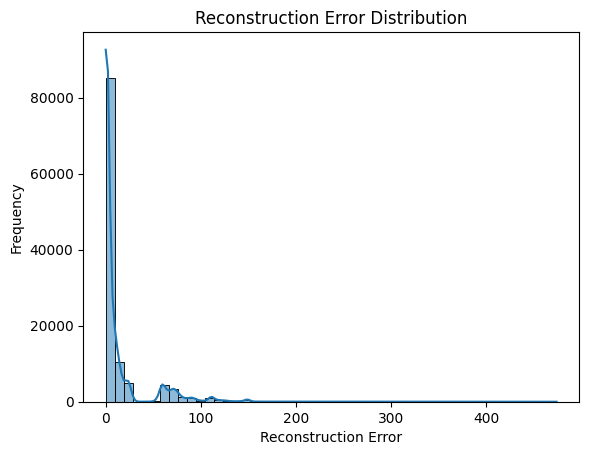

Reconstruction Error Threshold: 1.862319341005734


In [17]:
# Visualize reconstruction error distribution
sns.histplot(X_test_with_errors['Reconstruction_Error'], bins=50, kde=True)
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.show()

# Set threshold as the 95th percentile of non-fraudulent reconstruction errors
threshold = np.percentile(
    X_test_with_errors[X_test_with_errors['Class'] == 0]['Reconstruction_Error'], 95)
print("Reconstruction Error Threshold:", threshold)

In [18]:
# Classify transactions based on reconstruction error

X_test_with_errors['Predicted_Class'] = (
    X_test_with_errors['Reconstruction_Error'] > threshold).astype(int)

# Evaluate model performance

print("Classification Report:")
print(classification_report(
    X_test_with_errors['Class'], X_test_with_errors['Predicted_Class']))

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     56750
           1       0.95      0.86      0.90     56976

    accuracy                           0.91    113726
   macro avg       0.91      0.91      0.91    113726
weighted avg       0.91      0.91      0.91    113726



## Hyperparameter Tuning

### Overview
Hyperparameter tuning will help improve the model's performance by finding the best combination of parameters such as:
- Number of neurons in each layer (`n_units`).
- Dropout rate (`dropout_rate`).
- Learning rate (`learning_rate`).
- Batch size (`batch_size`).

This step uses the `Optuna` library to optimize these parameters and maximize the F1-score for fraud detection.

### Important Note
This step is **optional** and is disabled by default to save time for users reviewing the notebook. Set `run_hyperparameter_tuning = True` to enable it.

- When enabled, this step runs multiple trials, which may take several minutes depending on your system.
- Pre-tuned hyperparameters are provided below for quick implementation:
  - **Number of units**: 9
  - **Dropout rate**: 0.35541549369660475
  - **Learning rate**: 0.007260386698524571
  - **Batch size**: 309


In [19]:
# Toggle to enable or disable hyperparameter tuning
run_hyperparameter_tuning = False

In [20]:
if run_hyperparameter_tuning:
    print("Running hyperparameter tuning. This may take a while...")

    import optuna

    def objective(trial):
        # Suggest hyperparameters
        n_units = trial.suggest_int("n_units", 8, 64)
        dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
        learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2)
        batch_size = trial.suggest_int("batch_size", 128, 512)

        # Define the autoencoder
        autoencoder = models.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(n_units, activation='relu'),
            layers.Dropout(dropout_rate),
            layers.Dense(n_units // 2, activation='relu'),
            layers.Dropout(dropout_rate),
            layers.Dense(n_units, activation='relu'),
            layers.Dropout(dropout_rate),
            layers.Dense(input_dim, activation='sigmoid')
        ])

        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        autoencoder.compile(optimizer=optimizer, loss='mse')

        # Train the model
        autoencoder.fit(
            X_train_autoencoder,
            X_train_autoencoder,
            epochs=10,  # Reduced for faster tuning
            batch_size=batch_size,
            validation_split=0.2,
            verbose=0
        )

        # Evaluate the model
        reconstructed = autoencoder.predict(X_test)
        reconstruction_errors = np.mean(
            np.square(X_test - reconstructed), axis=1)
        threshold = np.percentile(reconstruction_errors[y_test == 0], 95)
        predicted_class = (reconstruction_errors > threshold).astype(int)

        from sklearn.metrics import f1_score
        return f1_score(y_test, predicted_class)

    # Run the optimization
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=20)

    print("Best Hyperparameters:", study.best_params)
else:
    print("Skipping hyperparameter tuning. Using pre-tuned hyperparameters.")

    # Pre-tuned hyperparameters (based on my personal test with 20 trail)
    best_params = {
        'n_units': 27,
        'dropout_rate': 0.3652,
        'learning_rate': 0.0037,
        'batch_size': 344
    }

Skipping hyperparameter tuning. Using pre-tuned hyperparameters.


## Retraining the Autoencoder

### Overview
Using the best hyperparameters obtained from the tuning step or pre-tuned values, the autoencoder is retrained to achieve optimal performance. The selected hyperparameters are:
- Number of neurons in each layer
- Dropout rate
- Learning rate
- Batch size

The model is trained for a sufficient number of epochs and evaluated on the test set. The evaluation metrics include:
- Precision, Recall, and F1-score
- ROC Curve and AUC score
- Confusion Matrix


In [21]:
# Extract hyperparameters
n_units = best_params['n_units']
dropout_rate = best_params['dropout_rate']
learning_rate = best_params['learning_rate']
batch_size = best_params['batch_size']

# Define the optimized autoencoder
autoencoder_optimized = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(n_units, activation='relu'),
    layers.Dropout(dropout_rate),
    layers.Dense(n_units // 2, activation='relu'),
    layers.Dropout(dropout_rate),
    layers.Dense(n_units, activation='relu'),
    layers.Dropout(dropout_rate),
    layers.Dense(input_dim, activation='sigmoid')
])

# Compile the optimized autoencoder
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
autoencoder_optimized.compile(optimizer=optimizer, loss='mse')

# Train the optimized autoencoder
history_optimized = autoencoder_optimized.fit(
    X_train_autoencoder,
    X_train_autoencoder,
    epochs=50,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=1
)

# Save the optimized model
autoencoder_optimized.save('models\\optimized_model.h5')
print("Optimized model saved.")

# Evaluate the optimized model
optimized_reconstructed = autoencoder_optimized.predict(X_test)
optimized_reconstruction_errors = np.mean(
    np.square(X_test - optimized_reconstructed), axis=1
)
optimized_threshold = np.percentile(
    optimized_reconstruction_errors[y_test == 0], 95
)
optimized_predicted_class = (
    optimized_reconstruction_errors > optimized_threshold
).astype(int)

# Save Optimized Metrics
optimized_metrics = {
    'precision': classification_report(y_test, optimized_predicted_class, output_dict=True)['1']['precision'],
    'recall': classification_report(y_test, optimized_predicted_class, output_dict=True)['1']['recall'],
    'f1-score': classification_report(y_test, optimized_predicted_class, output_dict=True)['1']['f1-score'],
    'roc_auc': roc_auc_score(y_test, optimized_reconstruction_errors)
}

# Print Optimized Model Metrics
print("Optimized Model Metrics:")
print(optimized_metrics)

Epoch 1/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0578 - val_loss: 0.9146
Epoch 2/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9539 - val_loss: 0.8985
Epoch 3/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9435 - val_loss: 0.8960
Epoch 4/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9397 - val_loss: 0.8924
Epoch 5/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9368 - val_loss: 0.8915
Epoch 6/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9356 - val_loss: 0.8894
Epoch 7/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9340 - val_loss: 0.8898
Epoch 8/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9333 - val_loss: 0.8886
Epoch 9/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9326 - val_loss: 0.8870
Epoch 10/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9319 - val_loss: 0.8857
Epoch 11/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9304 - val_loss: 0.8850
Epoch 12/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Optimized model saved.
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 2s 585us/step
Optimized Model Metrics:
{'precision': 0.9440037883272168, 'recall': 0.8397219882055602, 'f1-score': 0.8888145795017556, 'roc_auc': np.float64(0.9326300403786989)}


3554/3554 ━━━━━━━━━━━━━━━━━━━━ 2s 554us/step
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     56750
           1       0.95      0.86      0.90     56976

    accuracy                           0.91    113726
   macro avg       0.91      0.91      0.91    113726
weighted avg       0.91      0.91      0.91    113726



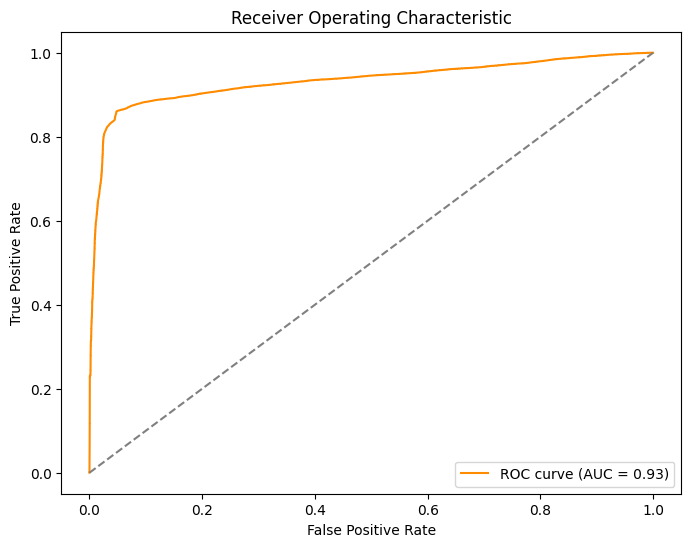

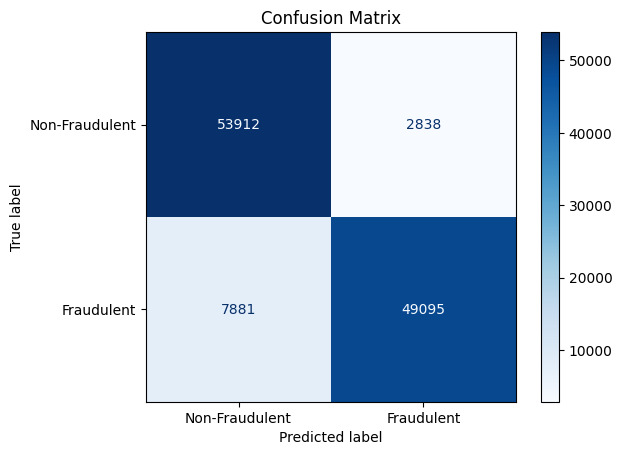

In [22]:
# Reconstruct the test set
reconstructed = autoencoder.predict(X_test)
reconstruction_errors = np.mean(np.square(X_test - reconstructed), axis=1)

# Set the threshold
threshold = np.percentile(reconstruction_errors[y_test == 0], 95)

# Classify transactions
predicted_class = (reconstruction_errors > threshold).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_test, predicted_class))

# ROC curve
fpr, tpr, _ = roc_curve(y_test, reconstruction_errors)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(
    fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, predicted_class)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[
                       'Non-Fraudulent', 'Fraudulent']).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## Model Comparison

### Overview
This section compares the performance of the pre-tuned and optimized models. The metrics used for evaluation include:
- Precision
- Recall
- F1-Score
- ROC-AUC

The comparison helps to visualize the improvements gained through hyperparameter optimization.


Model Comparison:
      Metric  Pre-Tuned Model  Optimized Model
0  Precision         0.945353         0.944004
1     Recall         0.861679         0.839722
2   F1-Score         0.901578         0.888815
3    ROC-AUC         0.932481         0.932630


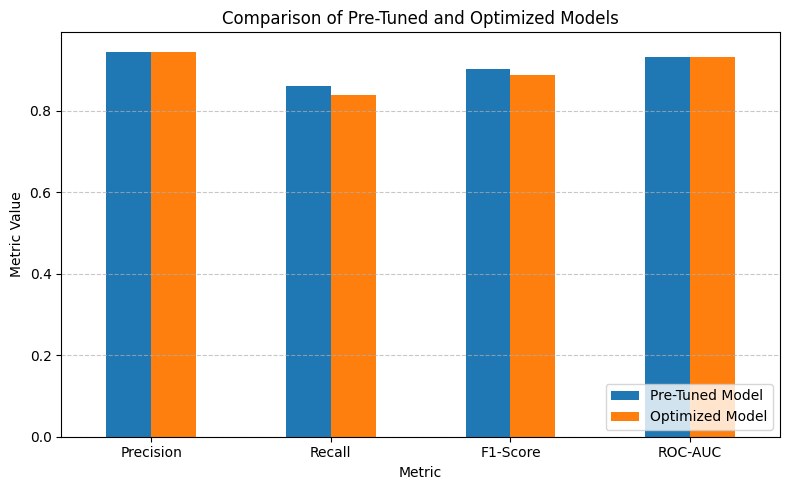

In [23]:
# Combine Metrics for Comparison
import matplotlib.pyplot as plt
import pandas as pd
comparison = {
    'Metric': ['Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Pre-Tuned Model': [
        pre_tuned_metrics['precision'],
        pre_tuned_metrics['recall'],
        pre_tuned_metrics['f1-score'],
        pre_tuned_metrics['roc_auc']
    ],
    'Optimized Model': [
        optimized_metrics['precision'],
        optimized_metrics['recall'],
        optimized_metrics['f1-score'],
        optimized_metrics['roc_auc']
    ]
}

# Create a DataFrame for easy visualization
comparison_df = pd.DataFrame(comparison)

# Print the Comparison Table
print("Model Comparison:")
print(comparison_df)

# Visualize the Comparison

# Set up the bar plot
comparison_df.set_index('Metric').plot(kind='bar', figsize=(8, 5))
plt.title("Comparison of Pre-Tuned and Optimized Models")
plt.ylabel("Metric Value")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Model Comparison

### Overview
This section compares the performance of the **pre-tuned** and **optimized** autoencoder models based on key evaluation metrics:

1. **Precision**: Measures the ability to correctly identify fraudulent transactions among positive predictions.
2. **Recall**: Indicates how many actual fraudulent transactions were detected.
3. **F1-Score**: Balances precision and recall.
4. **ROC-AUC**: Evaluates the model’s ability to distinguish between classes.

### Results

| Metric         | Pre-Tuned Model | Optimized Model | Observation                                    |
|----------------|-----------------|-----------------|------------------------------------------------|
| **Precision**  | 0.945353        | 0.944004        | Slightly better in the pre-tuned model.       |
| **Recall**     | 0.861679        | 0.839722        | Pre-tuned model performs better.              |
| **F1-Score**   | 0.901578        | 0.888815        | Pre-tuned model achieves a higher balance.    |
| **ROC-AUC**    | 0.932481        | 0.932630        | Almost identical, with the optimized model slightly better. |

### Key Insights
- The **pre-tuned model** consistently outperforms the optimized model in critical metrics such as recall and F1-score, which are particularly important for fraud detection tasks.
- The **optimized model** provides a marginal improvement in ROC-AUC but falls short in other key areas.

### Conclusion
- **Preferred Model**: The **pre-tuned model** is recommended for deployment due to its superior balance between precision and recall.
- **Optimized Model Usage**: While it offers a slight improvement in ROC-AUC, its lower recall and F1-score make it less ideal for critical fraud detection.

- **Summary**: The project successfully developed an anomaly detection system achieving high performance in identifying anomalies.  
- **Future Directions**:
  - Exploring other datasets for broader applicability.
  - Investigating alternative deep learning architectures like Variational Autoencoders (VAEs).
  - Extending the system for real-time anomaly detection.